In [1]:
# We need to join the upper directory in order to access the local modules
import os
import pickle
import sys

import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from pytdoa import nonlinoptim, linoptim  # noqa: E402
from pytdoa.mlat import exact
from pytdoa.geodesy import SPEED_OF_LIGHT  # noqa: E402
from pytdoa.helpers import moving_average # noqa: E402

In [296]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 18

In [6]:
# Reading the mat files
with open("comnets_data/gnbPositions.json") as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])
center = gNBs[3,:]
Rba = np.array([[np.cos(np.pi/2),-np.sin(np.pi/2),center[0]],[np.sin(np.pi/2),np.cos(np.pi/2),center[1]],[0.0,0.0,1.0]])
Rab = np.linalg.inv(Rba)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])
ggs = np.hstack((gNBs,np.ones((4,1))))
gNBs = np.matmul(Rab,ggs.T).T
gNBs = gNBs[:,0:2]

with open("comnets_data/uePositions.json") as ue_file:
    data = json.load(ue_file)

UEs = np.array(
    [data["ue0"], data["ue1"], data["ue2"], data["ue3"], data["ue4"], data["ue5"]]
)

uus = np.hstack((UEs,np.ones((6,1))))

UEs = np.matmul(Rab,uus.T).T
UEs = UEs[:,0:2]

## Playing a bit with the observed TDOA values

In [8]:
# Main params
POSITION = 0
FREQUENCY_MHZ = 80  # MHz
FREQUENCY = FREQUENCY_MHZ * 1e6

# Reading and filtering
toa_measurements = pd.read_csv(
    f"comnets_data/experiments/exp{POSITION}/{FREQUENCY_MHZ}mhz.csv"
)
toa_measurements.drop(
    [
        "Unnamed: 0",
    ],
    axis=1,
    inplace=True,
)

if FREQUENCY_MHZ == 100:
    if POSITION == 4:
        toa_measurements = toa_measurements.drop(["gNB0", "P0"], axis=1)

    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

    if POSITION == 1:
        toa_filt = toa_filt.loc[154:]  # Only for Position 1

elif FREQUENCY_MHZ == 40:
    if POSITION != 2:
        toa_measurements = toa_measurements.drop(["gNB0", "P0"], axis=1)
    else:
        toa_measurements = toa_measurements.drop(["gNB1", "P1"], axis=1)

    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

elif FREQUENCY_MHZ == 80:
    toa_measurements = toa_measurements.drop(["gNB1","P1"],axis=1)
    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)
else:
    raise RuntimeError("Not a supported frequency")
toa_filt.shape

(2085, 6)

In [9]:
# Calculating the theoretical values
th_toa = np.linalg.norm(UEs[POSITION] - gNBs, axis=1)
th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(4, k=1)]
th_tdoa

array([ 0.07449244,  0.71944549,  0.6470774 ,  0.64495304,  0.57258496,
       -0.07236809])

In [12]:
# Moving Average parameters
ma_window = 50

# Vectorized version to obtain TDOA values
if FREQUENCY_MHZ == 100:
    toas = toa_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
    triu_indices = np.triu_indices(4, k=1)
    tdoas = (
        toas.reshape((toas.shape[0], toas.shape[1], 1))
        - toas.reshape((toas.shape[0], 1, toas.shape[1]))
    )[:, triu_indices[0], triu_indices[1]]
elif FREQUENCY_MHZ == 80:
    toas = toa_filt[["gNB0", "gNB2", "gNB3"]].to_numpy()
    triu_indices = np.triu_indices(3, k=1)
    tdoas = (
        toas.reshape((toas.shape[0], toas.shape[1], 1))
        - toas.reshape((toas.shape[0], 1, toas.shape[1]))
    )[:, triu_indices[0], triu_indices[1]]
else:
    toas = toa_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
    triu_indices = np.triu_indices(3, k=1)
    tdoas = (
        toas.reshape((toas.shape[0], toas.shape[1], 1))
        - toas.reshape((toas.shape[0], 1, toas.shape[1]))
    )[:, triu_indices[0], triu_indices[1]]

# A bit of masking to remove obvious outliers
maskl, masku = (tdoas > -20), tdoas < 20
mask = (maskl & masku).all(axis=1)
tdoas = moving_average(tdoas[mask, :], ma_window)

tdoas = tdoas / FREQUENCY * SPEED_OF_LIGHT
tdoa_mean = np.mean(tdoas, axis=0)

In [22]:
experiment = 100
combination_range = itertools.combinations(np.arange(3), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

In [20]:
linpos = linoptim(gNBs,tdoas[experiment,:],input_type='xyz').squeeze()
print(f"Calculated Position - x: {linpos[0]:.4f} y: {linpos[1]:.4f}")
print(f"Real Position - x: {UEs[POSITION,0]:.4f} y: {UEs[POSITION,1]:.4f}")

Calculated Position - x: -46.9543 y: 179.9233
Real Position - x: 6.0700 y: 2.0400


In [23]:
result = nonlinoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, p0=linpos, input_type="xyz")
print(f"Calculated Position - x: {result[0]:.4f} y: {result[1]:.4f}")

Calculated Position - x: 5.0058 y: 4.8400


## Let's get TDOA offsets for all positions

In [271]:
gNBc = gNBs[:,0] + 1j*gNBs[:,1]
dmax = np.max(np.abs(gNBc.reshape(-1,1) - gNBc))
dmax

13.381816020256743

In [277]:
# Let's analyze one frequency at a time
frequency_mhz = 100  # MHz
frequency = frequency_mhz * 1e6
if frequency_mhz == 100:
    frequency = 122.88e6
elif frequency_mhz == 80:
    frequency = 92.16e6
elif frequency_mhz == 40:
    frequency = 61.44e6
ma_window = 10

result_dict = {}

result_dict["ma"] = ma_window
result_dict["frequency"] = frequency
result_dict["frequency_mhz"] = frequency_mhz
ngnb = 4
n = 4
for position in [0, 4, 5]:
    # Reading and filtering
    df = pd.read_csv(f"comnets_data/experiments/exp{position}/{frequency_mhz}mhz.csv")
    df.drop(
        [
            "Unnamed: 0",
        ],
        axis=1,
        inplace=True,
    )

    # This is internal knowledge
    if frequency_mhz == 100:
        if ngnb == 4:
            gnbs = gNBs
        else:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
            n = 3
            gnbs = gNBs[1:]

        df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)

        if position == 1:
            df_filt = df_filt.loc[154:]  # Only for Position 1

    elif frequency_mhz == 80:
        n = 3
        df.drop(["gNB1", "P1"], axis=1, inplace=True)
        gnbs = gNBs[[0, 2, 3], :]

        df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)

    elif frequency_mhz == 40:
        n = 3
        if position != 2:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
            gnbs = gNBs[1:, :]
        else:
            df.drop(["gNB1", "P1"], axis=1, inplace=True)
            gnbs = gNBs[[0, 2, 3], :]

        df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)

    else:
        raise RuntimeError("Unsupported frequency")

    # Calculating the theoretical values
    th_toa = np.linalg.norm(UEs[position] - gnbs, axis=1)
    th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(n, k=1)]
    result_dict[f"P{position}", "th_tdoa"] = th_tdoa

    # Vectorized version to obtain TDOA values
    if frequency_mhz == 100:
        if ngnb == 4:
            toas = df_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
        else:
            toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()

    elif frequency_mhz == 80:
        toas = df_filt[["gNB0", "gNB2", "gNB3"]].to_numpy()

    elif frequency_mhz == 40:
        if position == 1:
            continue
        elif position != 2:
            toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
        else:
            toas = df_filt[["gNB0", "gNB2", "gNB3"]].to_numpy()
    else:
        raise RuntimeError("Unsupported frequency")

    triu_indices = np.triu_indices(n, k=1)
    tdoas = (
        toas.reshape((toas.shape[0], toas.shape[1], 1))
        - toas.reshape((toas.shape[0], 1, toas.shape[1]))
    )[:, triu_indices[0], triu_indices[1]]

    # A bit of masking to remove obvious outliers
    mtdoa = dmax / SPEED_OF_LIGHT * frequency
    maskl, masku = (tdoas > -mtdoa), tdoas < mtdoa
    mask = (maskl & masku).all(axis=1)
    tdoas = moving_average(tdoas[mask, :], ma_window)
    tdoas = tdoas / frequency * SPEED_OF_LIGHT

    # Let's store our precious data
    result_dict[f"P{position}", "tdoas"] = tdoas
    result_dict[f"P{position}", "tdoas_mean"] = tdoas - th_tdoa

#
filename = f"{n}_{frequency_mhz}mhz_window_{ma_window}.pickle"
with open(f"comnets_data/results/offsets/{filename}", "wb") as handle:
    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Results saved to: {filename}")

Results saved to: 4_100mhz_window_10.pickle


## Result analysis

In [278]:
w = 50
with open(f'comnets_data/results/offsets/4_100mhz_window_{w}.pickle', 'rb') as p:
    data_100 = pickle.load(p)

with open(f'comnets_data/results/offsets/3_80mhz_window_{w}.pickle', 'rb') as p:
    data_80 = pickle.load(p)

with open(f'comnets_data/results/offsets/3_40mhz_window_{w}.pickle', 'rb') as p:
    data_40 = pickle.load(p)

w = 10
with open(f'comnets_data/results/offsets/4_100mhz_window_{w}.pickle', 'rb') as p:
    data_100_w10 = pickle.load(p)

with open(f'comnets_data/results/offsets/3_80mhz_window_{w}.pickle', 'rb') as p:
    data_80_w10 = pickle.load(p)

with open(f'comnets_data/results/offsets/3_40mhz_window_{w}.pickle', 'rb') as p:
    data_40_w10 = pickle.load(p)

In [279]:
gnb23_100 = np.array([])
gnb23_80 = np.array([])
gnb23_40 = np.array([])

wind = np.array([])
for p in [0,4,5]:
    gnb23_100 = np.append(gnb23_100,data_100[f'P{p}','tdoas_mean'][:,-1])
    wind = np.append(wind,['50'] * len(data_100[f'P{p}','tdoas_mean'][:,-1]))
    gnb23_100 = np.append(gnb23_100,data_100_w10[f'P{p}','tdoas_mean'][:,-1])
    wind = np.append(wind,['10'] * len(data_100_w10[f'P{p}','tdoas_mean'][:,-1]))

    gnb23_80 = np.append(gnb23_80,data_80[f'P{p}','tdoas_mean'][:,-1])
    wind = np.append(wind,['50'] * len(data_80[f'P{p}','tdoas_mean'][:,-1]))
    gnb23_80 = np.append(gnb23_80,data_80_w10[f'P{p}','tdoas_mean'][:,-1])
    wind = np.append(wind,['10'] * len(data_80_w10[f'P{p}','tdoas_mean'][:,-1]))

    gnb23_40 = np.append(gnb23_40,data_40[f'P{p}','tdoas_mean'][:,-1])
    wind = np.append(wind,['50'] * len(data_40[f'P{p}','tdoas_mean'][:,-1]))
    gnb23_40 = np.append(gnb23_40,data_40_w10[f'P{p}','tdoas_mean'][:,-1])
    wind = np.append(wind,['10'] * len(data_40_w10[f'P{p}','tdoas_mean'][:,-1]))

tdoas = np.append(gnb23_40,np.append(gnb23_80,gnb23_100))

tag_100 = len(gnb23_100) * ['100 MHz']
tag_80 = len(gnb23_80) * ['80 MHz']
tag_40 = len(gnb23_40) * ['40 MHz']
tags = np.append(tag_40, np.append(tag_80,tag_100))

In [280]:
df = pd.DataFrame()
df['Error'] = tdoas
df['Bandwidth'] = tags
df['Window Size'] = wind

In [291]:
p = sns.color_palette("pastel")
p[0] = (0.973, 0.463, 0.427)
p[1] = (0.38, 0.612, 1)
p

[(0.973, 0.463, 0.427),
 (0.38, 0.612, 1),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

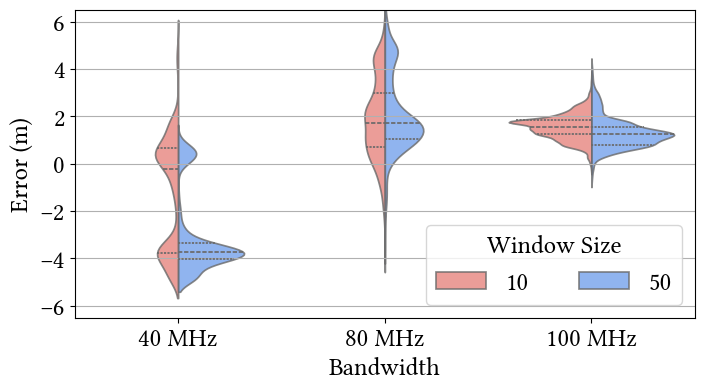

In [298]:
f, ax = plt.subplots(figsize=(8,4))
ax.grid()


sns.violinplot(df, x='Bandwidth', y='Error', hue='Window Size', hue_order=['10','50'], split=True, inner="quart", ax=ax, alpha=.8, palette=p[0:2])

ax.set_ylabel('Error (m)')
ax.set_yticks(np.arange(-6,7,2))
ax.set_ylim(-6.5,6.5)

ax.legend(loc='lower right', ncol=2, title='Window Size')

plt.savefig('../pics/comnets/offsets.pdf', format='pdf', bbox_inches='tight')
plt.show()